# Simulating Stellar Clusters with Brown Dwarfs

#### Importing Necessary Packages

In [1]:
# Import necessary packages. 
from spisea import synthetic, evolution, atmospheres, reddening, ifmr
from spisea.imf import imf, multiplicity
import numpy as np
import pandas as pd
import pylab as py
from scipy.interpolate import RegularGridInterpolator
import pdb
import matplotlib.pyplot as plt
from astropy.table import vstack
%matplotlib inline
%load_ext autoreload
%autoreload

## Creating Isochrone Extending to Substellar Range

In [2]:
# Create isochrone object  
filt_list = ['wfc3,ir,f153m'] # We won't be doing much with synthetic photometry here, so only need 1 filter
my_ifmr = ifmr.IFMR_Raithel18()
my_iso = synthetic.IsochronePhot(9, 0, 10,
                                 evo_model = evolution.MergedPhillipsBaraffePisaEkstromParsec(),  #our new evolution model for BDs
                                      filters=filt_list)


In [3]:
# Creating a sample BD case for identification
bd_idx = np.where((my_iso.points['mass'] > 0.01) & (my_iso.points['mass'] < 0.08) )[0]
if len(bd_idx) > 0:
    f153m = np.round(my_iso.points[bd_idx[0]]['m_hst_f153m'], decimals=3)
    mass = my_iso.points[bd_idx[0]]['mass']
    print('Brown dwarf (mass < 0.08 M_sun): F153M = {0} mag'.format(f153m))
else:
    print('No brown dwarf with mass < 0.08 M_sun found.')

Brown dwarf (mass < 0.08 M_sun): F153M = 19.201 mag


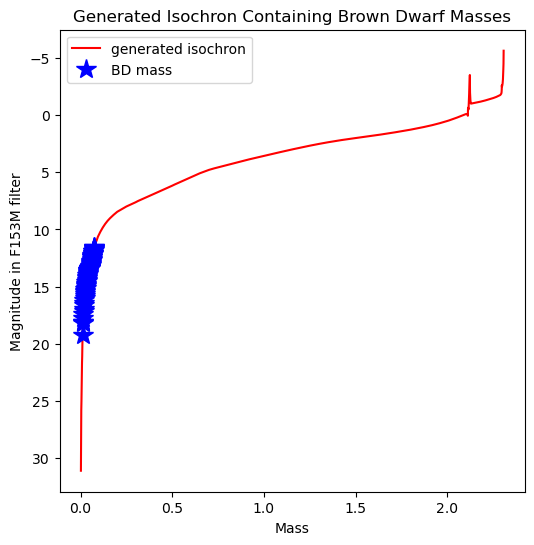

In [4]:
# Make a mass-magnitude diagram from the isochrone and plot brown dwarfs
py.figure(1, figsize=(6,6))
py.clf()
py.plot(my_iso.points['mass'], my_iso.points['m_hst_f153m'], 'r-', label='generated isochron')
py.plot(my_iso.points['mass'][bd_idx], my_iso.points['m_hst_f153m'][bd_idx], 'b*', ms=15, label='BD mass')
py.title('Generated Isochron Containing Brown Dwarf Masses')
py.xlabel('Mass')
py.ylabel('Magnitude in F153M filter')
py.gca().invert_yaxis()
py.legend()
py.show()

## Case 1: Cluster Without Companions

For this stellar cluster, we will be using the MergedBaraffePisaEkstromParsec evolution model, IMFR_Raithel18 initial-final mass relation, and the Salpeter_Kirkpatrick_2024 initial mass function, all of which have been modified to describe substellar masses.

In [5]:
# Create IMF object without companions 
k_imf = imf.Salpeter_Kirkpatrick_2024()

In [6]:
# Make cluster
cluster_mass = 10**6
k_cluster = synthetic.ResolvedCluster(my_iso, k_imf, cluster_mass, ifmr=my_ifmr)

# Get outputs
k_out = k_cluster.star_systems

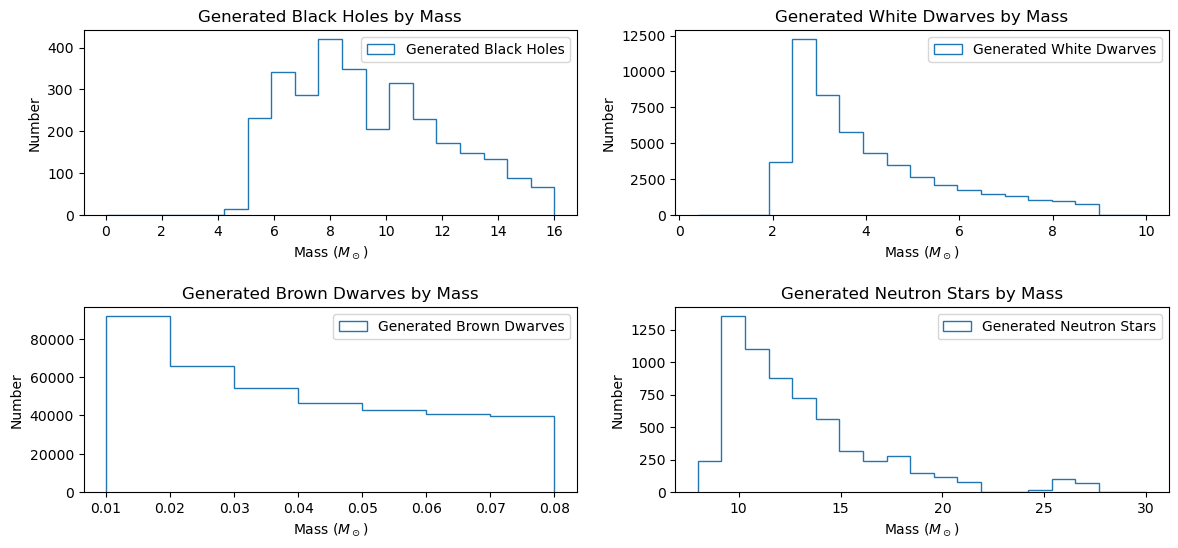

In [7]:
# Locate BHs, NSs, WDs, and BDs
p_bh = np.where(k_out['phase'] == 103)[0]
p_ns = np.where(k_out['phase'] == 102)[0]
p_wd = np.where(k_out['phase'] == 101)[0]
p_bd = np.where(k_out['phase'] == 90)[0]

# Determine individual histogram bins
bh_bins = np.linspace(0.01, 16, 20)
wd_bins = np.linspace(0.4, 10, 20)
bd_bins = np.linspace(0.01, 0.08, 8)
ns_bins = np.linspace(8, 30, 20)

# Plot BHs
plt.figure(figsize=(14,6))
plt.subplot(2, 2, 1)
plt.hist(k_out[p_bh]['mass_current'], histtype = 'step',
        bins = bh_bins, label = 'Generated Black Holes')
plt.title("Generated Black Holes by Mass")
plt.xlabel('Mass ($M_\odot$)')
plt.ylabel('Number')
plt.legend()

# Plot WDs
plt.subplot(2, 2, 2)
plt.hist(k_out[p_wd]['mass'], histtype = 'step',
        bins = wd_bins, label = 'Generated White Dwarves')
plt.title("Generated White Dwarves by Mass")
plt.xlabel('Mass ($M_\odot$)')
plt.ylabel('Number')
plt.legend()

# Plot BDs
plt.subplot(2, 2, 3)
plt.hist(k_out[p_bd]['mass_current'], histtype = 'step',
        bins = bd_bins, label = 'Generated Brown Dwarves')
plt.title("Generated Brown Dwarves by Mass")
plt.xlabel('Mass ($M_\odot$)')
plt.ylabel('Number')
plt.legend()

# Plot NSs
plt.subplot(2, 2, 4)
plt.hist(k_out[p_ns]['mass'], histtype = 'step',
        bins = ns_bins, label = 'Generated Neutron Stars')
plt.title("Generated Neutron Stars by Mass")
plt.xlabel('Mass ($M_\odot$)')
plt.ylabel('Number')
plt.legend()

# Adjust space between subplots
plt.subplots_adjust(hspace=0.5)

plt.show()

In [8]:
# Checking that objects are in the correct mass ranges
print("BH max mass: " + str(np.max(k_out[p_bh]['mass'])))
print("BH min mass: " + str(np.min(k_out[p_bh]['mass'])) + '\n')

print("NS max mass: " + str(np.max(k_out[p_ns]['mass'])))
print("NS min mass: " + str(np.min(k_out[p_ns]['mass'])) + '\n')

print("WD max mass: " + str(np.max(k_out[p_wd]['mass'])))
print("WD min mass: " + str(np.min(k_out[p_wd]['mass'])) + '\n')

print("BD max mass: " + str(np.max(k_out[p_bd]['mass'])))
print("BD min mass: " + str(np.min(k_out[p_bd]['mass'])) + '\n')

BH max mass: 119.66334547857207
BH min mass: 15.0000788054688

NS max mass: 119.69186137462842
NS min mass: 9.00041007150772

WD max mass: 8.999600545649336
WD min mass: 2.3067911099815683

BD max mass: 0.07999963770010694
BD min mass: 0.010000021076120833



It is worth noting [explain about big NS's after confirmation from Matt] ..... 
white dwarfs capped at low end due to age of cluster

## Case 2: Cluster With Companions

For this cluster we are using the same isochrone as the one generated in Case 1, just changing our IMF to allow for systems with companions. We then record the number of progenitors in each mass bin for black holes, neutron stars, white dwarfs, and brown dwarfs. We can then view how they all evolve over time.

In [9]:
# Create IMF objects                                                                                                                                                     
imf_multi = multiplicity.MultiplicityUnresolved()
kc_imf = imf.Salpeter_Kirkpatrick_2024(multiplicity=imf_multi)

In [10]:
# Make cluster
cluster_mass = 10**6
kc_cluster = synthetic.ResolvedCluster(my_iso, kc_imf, cluster_mass, ifmr=my_ifmr)

# Get outputs
kc_out = kc_cluster.star_systems
kc_comp = kc_cluster.companions

Found 19241 companions out of stellar mass range


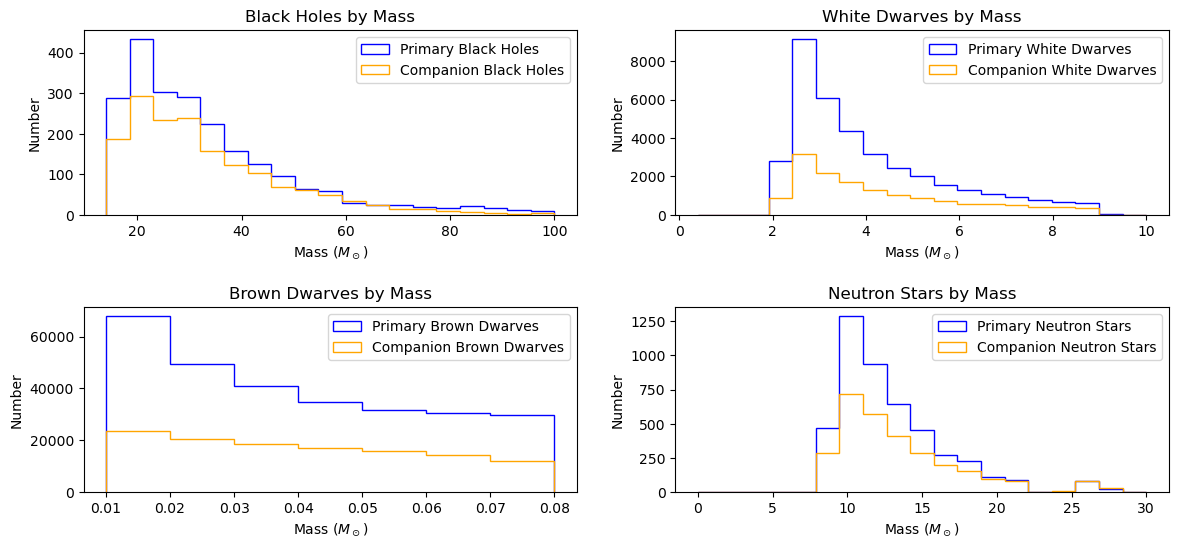

In [11]:
# Locate BHs, NSs, WDs, and BDs
p2_bh = np.where(kc_out['phase'] == 103)[0]
c_bh = np.where(kc_comp['phase'] == 103)[0]
p2_ns = np.where(kc_out['phase'] == 102)[0]
c_ns = np.where(kc_comp['phase'] == 102)[0]
p2_wd = np.where(kc_out['phase'] == 101)[0]
c_wd = np.where(kc_comp['phase'] == 101)[0]
p2_bd = np.where(kc_out['phase'] == 90)[0]
c_bd = np.where(kc_comp['phase'] == 90)[0]

# Define bins for histograms
bh_bins = np.linspace(14, 100, 20)
wd_bins = np.linspace(0.4, 10, 20)
bd_bins = np.linspace(0.01, 0.08, 8)
ns_bins = np.linspace(0, 30, 20)

# Create subplots
plt.figure(figsize=(14,6))

# Plot BHs
plt.subplot(2, 2, 1)
plt.hist(kc_out[p2_bh]['mass'], histtype='step', bins=bh_bins, label='Primary Black Holes', color='blue')
plt.hist(kc_comp[c_bh]['mass'], histtype='step', bins=bh_bins, label='Companion Black Holes', color='orange')
plt.title("Black Holes by Mass")
plt.xlabel('Mass ($M_\odot$)')
plt.ylabel('Number')
plt.legend()

# Plot WDs
plt.subplot(2, 2, 2)
plt.hist(kc_out[p2_wd]['mass'], histtype='step', bins=wd_bins, label='Primary White Dwarves', color='blue')
plt.hist(kc_comp[c_wd]['mass'], histtype='step', bins=wd_bins, label='Companion White Dwarves', color='orange')
plt.title("White Dwarves by Mass")
plt.xlabel('Mass ($M_\odot$)')
plt.ylabel('Number')
plt.legend()

# Plot BDs
plt.subplot(2, 2, 3)
plt.hist(kc_out[p2_bd]['mass'], histtype='step', bins=bd_bins, label='Primary Brown Dwarves', color='blue')
plt.hist(kc_comp[c_bd]['mass'], histtype='step', bins=bd_bins, label='Companion Brown Dwarves', color='orange')
plt.title("Brown Dwarves by Mass")
plt.xlabel('Mass ($M_\odot$)')
plt.ylabel('Number')
plt.legend()

# Plot NSs
plt.subplot(2, 2, 4)
plt.hist(kc_out[p2_ns]['mass'], histtype='step', bins=ns_bins, label='Primary Neutron Stars', color='blue')
plt.hist(kc_comp[c_ns]['mass'], histtype='step', bins=ns_bins, label='Companion Neutron Stars', color='orange')
plt.title("Neutron Stars by Mass")
plt.xlabel('Mass ($M_\odot$)')
plt.ylabel('Number')
plt.legend()

# Adjust space between subplots
plt.subplots_adjust(hspace=0.5)

# Show the plots
plt.show()


In [12]:
# Checking that objects are in the correct mass ranges
print("BH prim max mass: " + str(np.max(kc_out['mass'][p2_bh])))
print("BH prim min mass: " + str(np.min(kc_out['mass'][p2_bh])))
print("BH comp max mass: " + str(np.max(kc_comp['mass'][c_bh])))
print("BH comp min mass: " + str(np.min(kc_comp['mass'][c_bh])) + '\n')

print("NS prim max mass: " + str(np.max(kc_out[p2_ns]['mass'])))
print("NS prim min mass: " + str(np.min(kc_out[p2_ns]['mass'])))
print("NS comp max mass: " + str(np.max(kc_comp[c_ns]['mass'])))
print("NS comp min mass: " + str(np.min(kc_comp[c_ns]['mass'])) + '\n')

print("WD prim max mass: " + str(np.max(kc_out[p2_wd]['mass'])))
print("WD prim min mass: " + str(np.min(kc_out[p2_wd]['mass'])))
print("WD comp max mass: " + str(np.max(kc_comp[c_wd]['mass'])))
print("WD comp min mass: " + str(np.min(kc_comp[c_wd]['mass'])) + '\n')

print("BD prim max mass: " + str(np.max(kc_out[p2_bd]['mass'])))
print("BD prim min mass: " + str(np.min(kc_out[p2_bd]['mass'])))
print("BD comp max mass: " + str(np.max(kc_comp[c_bd]['mass'])))
print("BD comp min mass: " + str(np.min(kc_comp[c_bd]['mass'])) + '\n')

BH prim max mass: 119.81313623903503
BH prim min mass: 15.00991526273759
BH comp max mass: 117.87922107922613
BH comp min mass: 15.025589362143613

NS prim max mass: 118.77258608698675
NS prim min mass: 9.000462873651996
NS comp max mass: 112.7083837457762
NS comp min mass: 9.001307704298794

WD prim max mass: 8.999282260049943
WD prim min mass: 2.3066340801114324
WD comp max mass: 8.995879334368274
WD comp min mass: 2.306670656743985

BD prim max mass: 0.07999996275188857
BD prim min mass: 0.010000063950493392
BD comp max mass: 0.07999976499332974
BD comp min mass: 0.010000270279172984



All of our brown dwarf primary and companion progenitor objects are in the correct mass range! Now let's see how everything evolves over time!

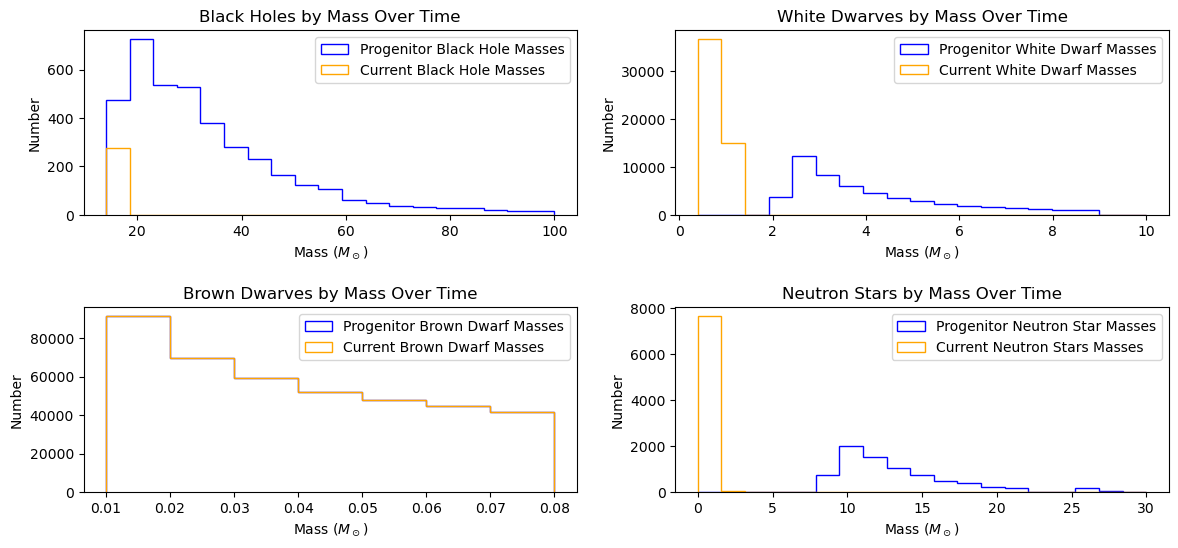

In [13]:
# Locate BHs, NSs, WDs, and BDs
p2_bh = np.where(kc_out['phase'] == 103)[0]
c_bh = np.where(kc_comp['phase'] == 103)[0]
k_bh = vstack([kc_out[p2_bh], kc_comp[c_bh]])
p2_ns = np.where(kc_out['phase'] == 102)[0]
c_ns = np.where(kc_comp['phase'] == 102)[0]
k_ns = vstack([kc_out[p2_ns], kc_comp[c_ns]])
p2_wd = np.where(kc_out['phase'] == 101)[0]
c_wd = np.where(kc_comp['phase'] == 101)[0]
k_wd = vstack([kc_out[p2_wd], kc_comp[c_wd]])
p2_bd = np.where(kc_out['phase'] == 90)[0]
c_bd = np.where(kc_comp['phase'] == 90)[0]
k_bd = vstack([kc_out[p2_bd], kc_comp[c_bd]])

# Create subplots
plt.figure(figsize=(14,6))

# Plot BHs
plt.subplot(2, 2, 1)
plt.hist(k_bh['mass'], histtype='step', bins=bh_bins, label='Progenitor Black Hole Masses', color='blue')
plt.hist(k_bh['mass_current'], histtype='step', bins=bh_bins, label='Current Black Hole Masses', color='orange')
plt.title("Black Holes by Mass Over Time")
plt.xlabel('Mass ($M_\odot$)')
plt.ylabel('Number')
plt.legend()

# Plot WDs
plt.subplot(2, 2, 2)
plt.hist(k_wd['mass'], histtype='step', bins=wd_bins, label='Progenitor White Dwarf Masses', color='blue')
plt.hist(k_wd['mass_current'], histtype='step', bins=wd_bins, label='Current White Dwarf Masses', color='orange')
plt.title("White Dwarves by Mass Over Time")
plt.xlabel('Mass ($M_\odot$)')
plt.ylabel('Number')
plt.legend()

# Plot BDs
plt.subplot(2, 2, 3)
plt.hist(k_bd['mass'], histtype='step', bins=bd_bins, label='Progenitor Brown Dwarf Masses', color='blue')
plt.hist(k_bd['mass_current'], histtype='step', bins=bd_bins, label='Current Brown Dwarf Masses', color='orange')
plt.title("Brown Dwarves by Mass Over Time")
plt.xlabel('Mass ($M_\odot$)')
plt.ylabel('Number')
plt.legend()

# Plot NSs
plt.subplot(2, 2, 4)
plt.hist(k_ns['mass'], histtype='step', bins=ns_bins, label='Progenitor Neutron Star Masses', color='blue')
plt.hist(k_ns['mass_current'], histtype='step', bins=ns_bins, label='Current Neutron Stars Masses', color='orange')
plt.title("Neutron Stars by Mass Over Time")
plt.xlabel('Mass ($M_\odot$)')
plt.ylabel('Number')
plt.legend()

# Adjust space between subplots
plt.subplots_adjust(hspace=0.5)

# Show the plots
plt.show()


We expect brown dwarfs to not change over time, which is consistent with evolutionary models imposed for these objects.